In [1]:
import time
import copy

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from sklearn import metrics
import os

# Load PlantVillage Dataset

In [2]:
#Organizing the dataset
batch_size = 32

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
train_on_gpu_mps = torch.backends.mps.is_available()

if train_on_gpu:
    print('CUDA is available.  Training on GPU ...')
    device = torch.device("cuda:0")
if train_on_gpu_mps:
    print('MPS is available!  Training on GPU ...')
    device = torch.device("mps")
else:
    print('Training on CPU ...')
    device = torch.device("cpu")
print(device)

MPS is available!  Training on GPU ...
mps


In [3]:
def balanced_sampler_weights(images, nclasses):
  count = [0] * nclasses
  for img in images:
    count[img[1]] += 1
  total_num_imgs = float(sum(count))

  weight_per_class = [total_num_imgs/float(count[i]) for i in range(nclasses)]
  weight_per_img = [weight_per_class[img[1]] for _, img in enumerate(images)]
  return weight_per_img

In [4]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        # transforms.RandomAffine(0,shear=30),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/PlantVillage-Apple/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

balance_classes = False

if balance_classes:
  train_weights = balanced_sampler_weights(image_datasets['train'].imgs, len(image_datasets['train'].classes))
  train_weights = torch.DoubleTensor(train_weights)
  train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_weights, len(train_weights))
  samplers = {'train': train_sampler, 'val': None}

  # Using the image datasets and the trainforms, define the dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, sampler=samplers[x], num_workers=4) for x in ['train', 'val']}
else:
  print("No balancing")
  # Using the image datasets and the trainforms, define the dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# data
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

No balancing
torch.Size([32, 3, 224, 224]) torch.Size([32])


In [5]:
tmp = dataloaders['train']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


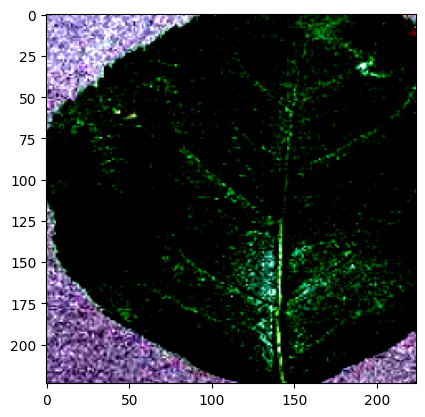

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


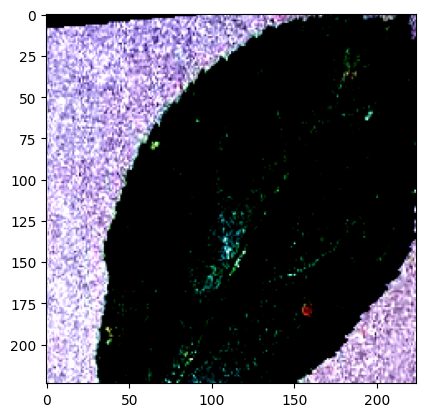

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


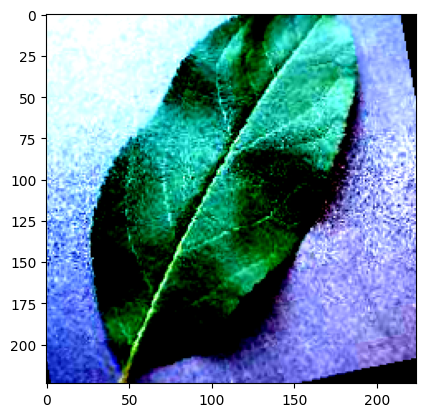

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


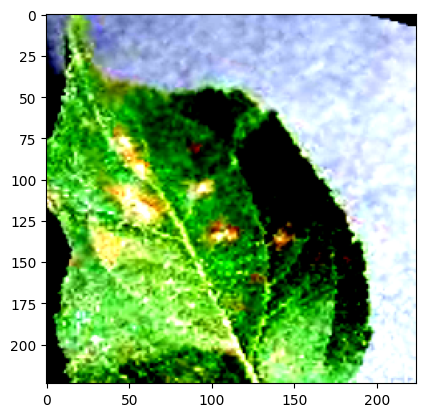

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


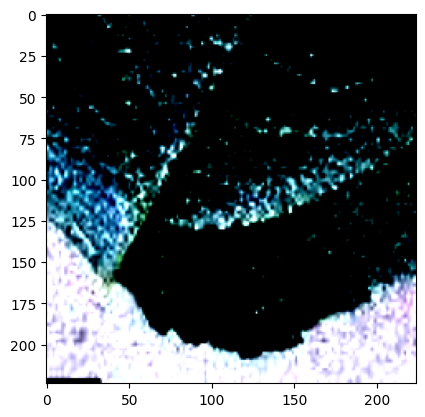

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


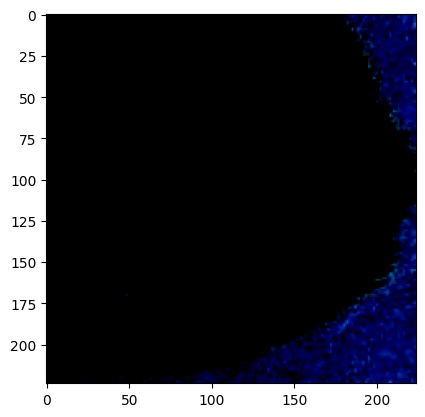

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


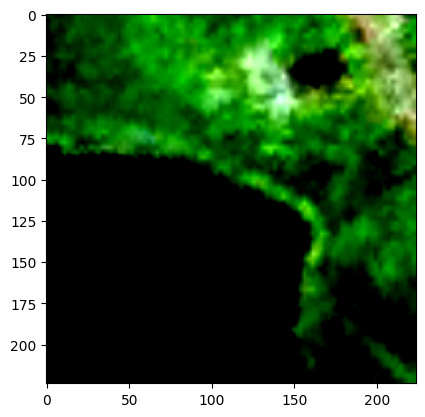

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


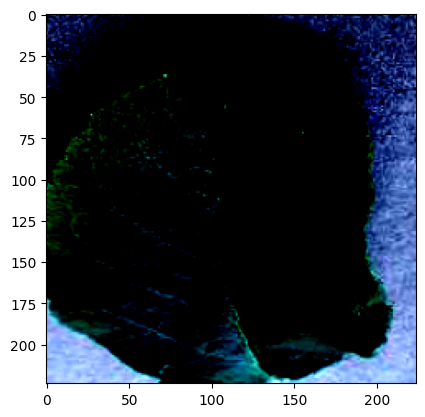

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


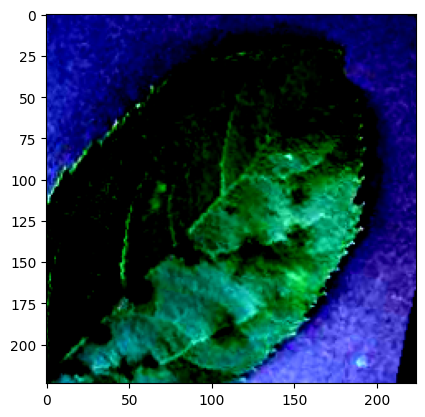

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])
(224, 224, 3)


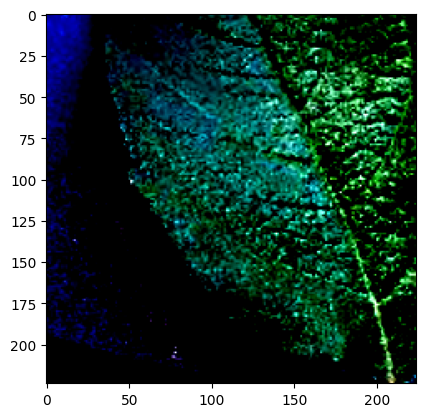

In [6]:
num_images_show = 10
i = 0
for x in tmp:
  print(np.transpose(x[0][0], (1,2,0)).shape)
  tmp_img = np.transpose(x[0][0].numpy(), (1,2,0))
  print(tmp_img.shape)
  plt.imshow(tmp_img)
  plt.show()
  i+=1
  if i >= num_images_show:
    break

In [7]:
buckets_split = {}
for split in ['train', 'val']:
  classes = image_datasets[split].classes
  buckets_split[split] = {x: 0 for x in classes}

for split in ['train', 'val']:
  ds = dataloaders[split]
  for data, batch_target in ds:
    for target in batch_target:
      class_idx = target.item()
      buckets_split[split][classes[class_idx]] += 1

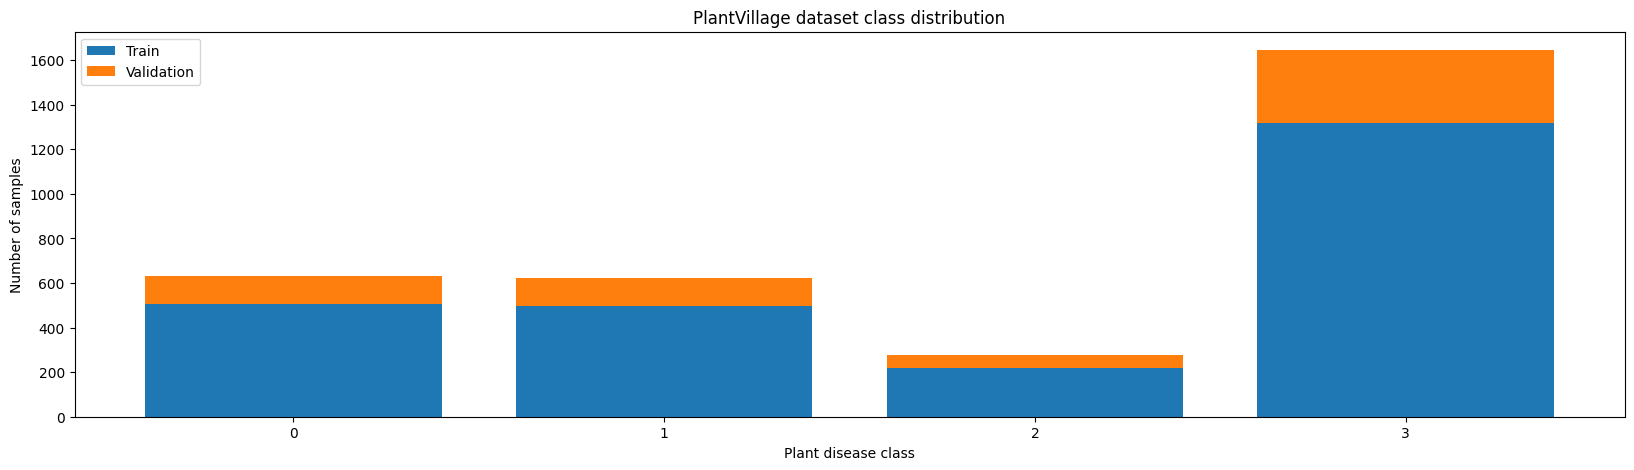

In [8]:
plt.figure(figsize=(20,5))
ind = range(len(buckets_split['train'].keys()))
p1 = plt.bar(ind,list(buckets_split['train'].values()))
p2 = plt.bar(ind,list(buckets_split['val'].values()), bottom=list(buckets_split['train'].values()))
plt.title("PlantVillage dataset class distribution")
plt.ylabel('Number of samples')
plt.xlabel('Plant disease class')
plt.xticks(ind)
plt.legend((p1[0], p2[0]), ('Train', 'Validation'))
plt.show()

# Build and train classifier

In [9]:
model = models.resnet50(pretrained=True)

# for param in model.parameters():
#   param.requires_grad = False
# model = models.resnet50(pretrained=True)

/Users/harshmohankulkarni/miniconda3/envs/plant-torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/harshmohankulkarni/miniconda3/envs/plant-torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                        ('relu', nn.ReLU()),
                                        ('fc2', nn.Linear(512,4)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.fc = classifier

In [11]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Train and update weights
        for inputs, labels in dataloaders['train']:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          # Forward
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs,1)

          # Backward + optimize
          loss.backward()
          optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        # Each epoch has a training and validation phase
        scheduler.step()
        running_loss = np.float32(running_loss)
        running_corrects = np.float32(running_corrects.cpu())
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects / dataset_sizes['train']

        print(f"Train Loss: {epoch_loss} Acc: {epoch_acc}")

        # Evaluate on validation set
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        running_loss = np.float32(running_loss)
        running_corrects = np.float32(running_corrects.cpu())
        epoch_loss = running_loss / dataset_sizes['val']
        epoch_acc = running_corrects / dataset_sizes['val']

        print(f"Validation Loss: {epoch_loss} Acc: {epoch_acc}")

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        if epoch % 5 == 0:
            # Save model every 5 epochs
            model.epochs = epoch
            checkpoint = {'input_size': [3, 224, 224],
                  'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'epoch': model.epochs}
            torch.save(checkpoint, f"classifier_{epoch}_epochs_checkpoint.pth")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Train the classifier

In [12]:
# Train a model with a pre-trained network
num_epochs = 5
if train_on_gpu:
    print ("Using GPU: "+ str(train_on_gpu))
    model = model.cuda()
if train_on_gpu_mps:
    print ("Using GPU: "+ str(train_on_gpu_mps))
    model = model.to(device)

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Using GPU: True
Epoch 1/5
----------
Train Loss: 0.5868702596670445 Acc: 0.777602523659306
Validation Loss: 0.19461093211737204 Acc: 0.9496062992125984
Epoch 2/5
----------
Train Loss: 0.2937814128887766 Acc: 0.8978706624605678


python(79064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Loss: 0.12824445108729085 Acc: 0.9622047244094488
Epoch 3/5
----------


python(79105) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79106) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.2147532321677223 Acc: 0.9207413249211357


python(79227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Loss: 0.09846160167784203 Acc: 0.9637795275590552
Epoch 4/5
----------


python(79243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.22138026384901174 Acc: 0.918769716088328


python(79404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Loss: 0.06378217081385334 Acc: 0.9811023622047244
Epoch 5/5
----------


python(79457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 0.16163252580805157 Acc: 0.9373028391167192


python(79655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Validation Loss: 0.11422775148406743 Acc: 0.9543307086614173
Training complete in 14m 2s
Best valid accuracy: 0.981102


In [15]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  label_accuracy = {x: 0 for x in image_datasets['val'].classes}
  predicted_labels = []
  true_labels = []

  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    acc = equality.type_as(torch.FloatTensor())
    accuracy += acc.mean()
    for i,x in enumerate(labels.data):
      label_accuracy[image_datasets['val'].classes[x]] += acc[i]
      predicted_labels.append(ps.max(1)[1][i])
      true_labels.append(x)

  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

  return true_labels, predicted_labels

In [16]:
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'epoch': model.epochs}
torch.save(checkpoint, './plantvillage_apple_resnet50_checkpoint.pth')

In [17]:
true_labels, predicted_labels = test(model, dataloaders, device)

python(79860) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79861) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(79863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Testing Accuracy: 0.981


In [18]:
predicted_labels_list = [x.cpu().item() for x in predicted_labels]
true_labels_list = [x.cpu().item() for x in true_labels]

In [19]:
# Print the confusion matrix
print(metrics.confusion_matrix(true_labels_list, predicted_labels_list))

# Print the precision and recall, among other metrics
print(metrics.classification_report(true_labels_list, predicted_labels_list, target_names=image_datasets['val'].classes, digits=3))

[[121   0   0   5]
 [  0 125   0   0]
 [  2   0  53   0]
 [  2   3   0 324]]
                          precision    recall  f1-score   support

      Apple___Apple_scab      0.968     0.960     0.964       126
       Apple___Black_rot      0.977     1.000     0.988       125
Apple___Cedar_apple_rust      1.000     0.964     0.981        55
         Apple___healthy      0.985     0.985     0.985       329

                accuracy                          0.981       635
               macro avg      0.982     0.977     0.980       635
            weighted avg      0.981     0.981     0.981       635



In [56]:
#Here we will check the accuray on the generated images.
import torch
import torchvision.transforms as transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = './final_output copy.png'
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

In [57]:
print(outputs)
print(predicted)

tensor([[-2.7776, -0.3140, -4.2447, -1.6453]], device='mps:0')
tensor([1], device='mps:0')
